## Testing affinity loop with multiple reaction steps

Data.

In [197]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Docking.

In [199]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 11
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'gnina',
    'seed': 5,
    **config_
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{dockstring_dir}/{target}',
    config=config
)

Designer.

In [200]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [201]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

In [387]:
import numpy as np

scores = docking_oracle(library)
best = np.nanargmax(scores).item()
print(np.nanmax(scores))
print(best)

for step in tqdm(range(5)):
    
    if step == 3:
        library += designer.design(library[best], 20, mode='grow')
    else:
        library += designer.design(library[best], 20, mode='replace')

    scores = docking_oracle(library)
    best = np.nanargmax(scores).item()
    
    print(step, np.nanmax(scores))
    print(step, best)

7.417436794281192
100


  0%|          | 0/5 [00:00<?, ?it/s]

0 7.417436794281192
0 100
1 7.417436794281192
1 100
2 7.417436794281192
2 100
3 7.509504976114245
3 180
4 7.573544206550928
4 188


Text(0.5, 1.0, 'Heavy atom count vs. pIC50')

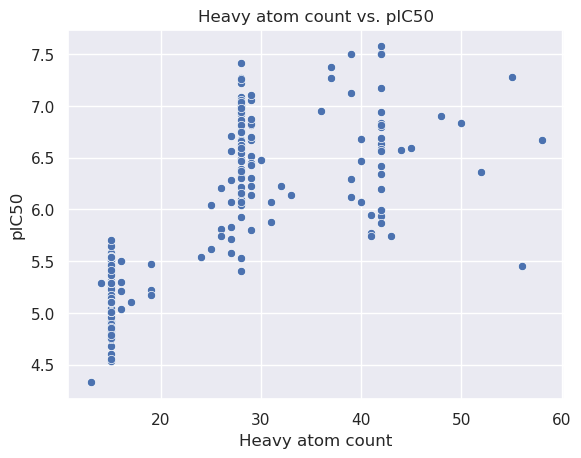

In [390]:
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')

In [349]:
from tqdm.notebook import tqdm

results = []
medians = []
for num_replicates in tqdm([1, 2, 4, 8, 16, 32, 64]):
    
    result = docking_oracle([library[best]] * num_replicates, use_cache=False)
    results.append(result)
    
    median = np.median(result)
    medians.append(median)

  0%|          | 0/7 [00:00<?, ?it/s]

Text(36.875, 0.5, 'pIC50')

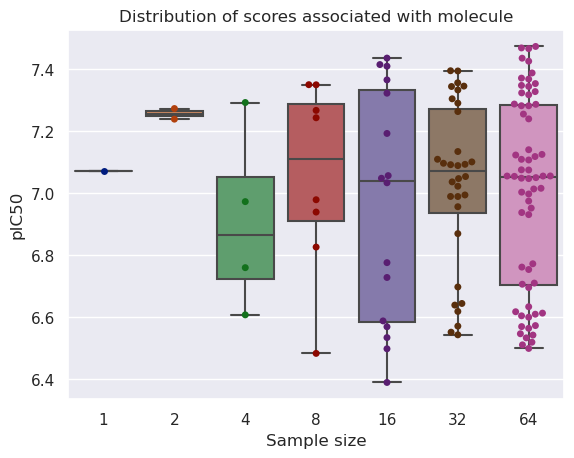

In [386]:
sns.boxplot(results, showfliers=False)
sns.swarmplot(results, palette='dark')

plt.title('Distribution of scores associated with molecule')
plt.xticks([0, 1,2,3,4,5, 6], [1, 2, 4, 8, 16, 32, 64])
plt.xlabel('Sample size')
plt.ylabel('pIC50')

Text(0.5, 1.0, 'Docking of a single molecule across replicates')

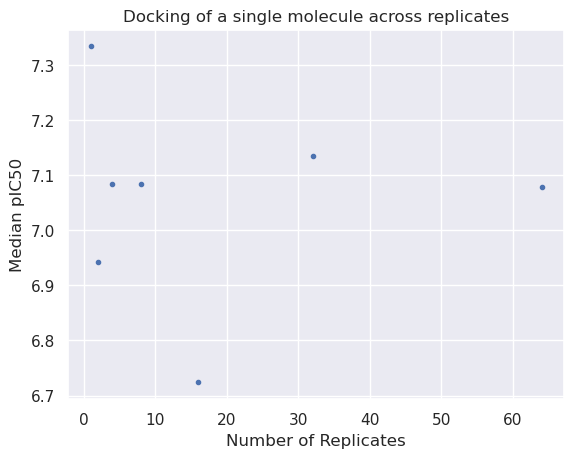

In [348]:
plt.plot([1, 2, 4, 8, 16, 32, 64], medians, '.')
plt.xlabel('Number of Replicates')
plt.ylabel('Median pIC50')
plt.title('Docking of a single molecule across replicates')

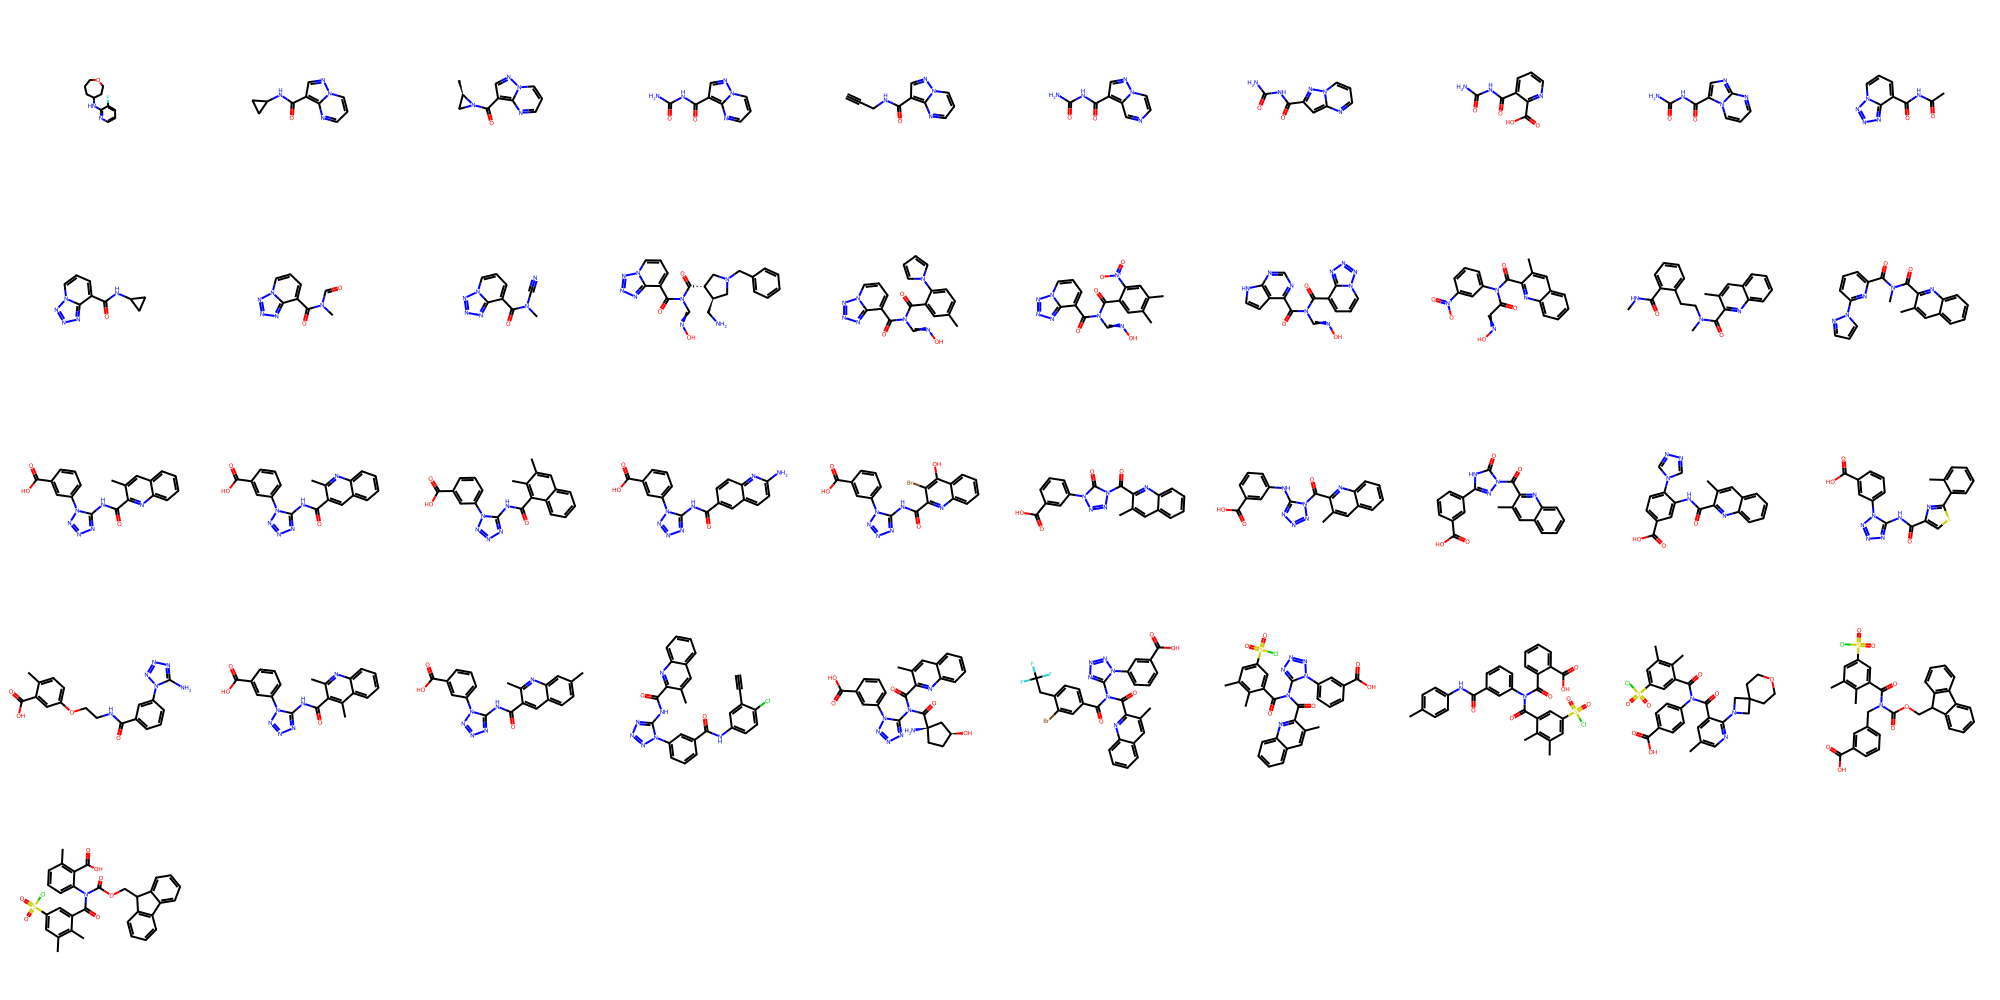

In [391]:
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage([m.mol for m in library[::5]], molsPerRow=10)

In [417]:
records = []
for idx, (mol, score) in enumerate(zip(library, scores)):
    records.append({'score': score, 'timestep': 1 + ((idx - 5) // 20)})
    
import pandas as pd
df = pd.DataFrame(records)

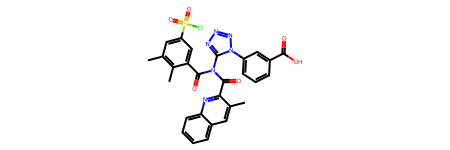

In [434]:
library[180]

Draw the best molecules from each round.

In [459]:
scores[180]

7.509504976114245

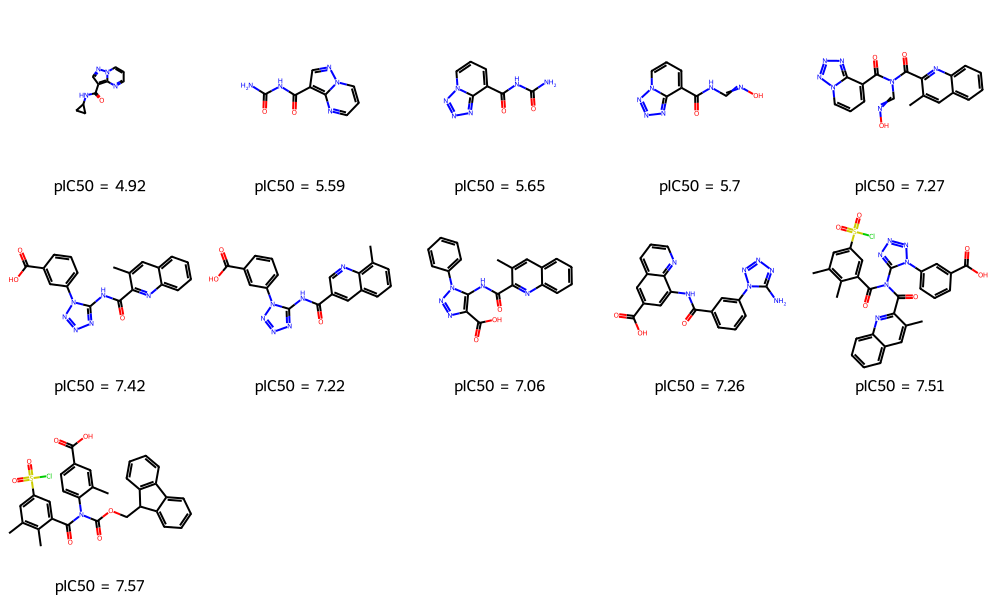

In [460]:
best_across_round = [df.query(f'timestep == {i}')['score'].sort_values().index[-1] for i in range(11)]
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(scores[b], 2)}' for b in best_across_round]
)

Draw the molecules associated with each round.

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'New compounds synthesized each round')

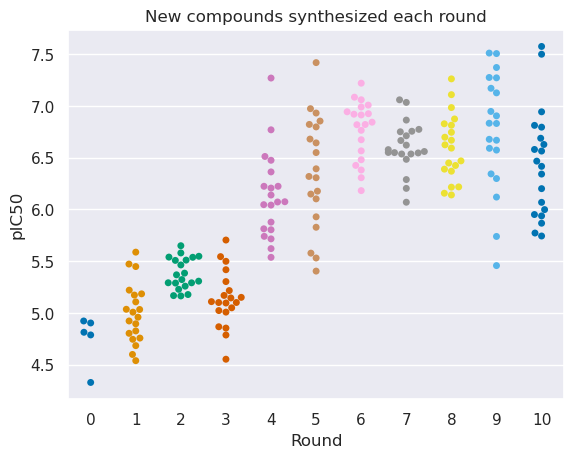

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.swarmplot(
    df,
    y='score',
    x='timestep',
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [395]:
import pandas as pd

records = []
max_timestep = ((len(library) - 5) // 20)  # Calculate the maximum possible timestep

for idx, (mol, score) in enumerate(zip(library, scores)):
    current_timestep = 1 + ((idx - 5) // 20)
    records.append({'score': score, 'timestep': current_timestep})

    # Duplicate logic for each possible timestep
    for t in range(1, max_timestep + 1):
        if current_timestep < t:
            records.append({'score': score, 'timestep': t})

df = pd.DataFrame(records)

Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

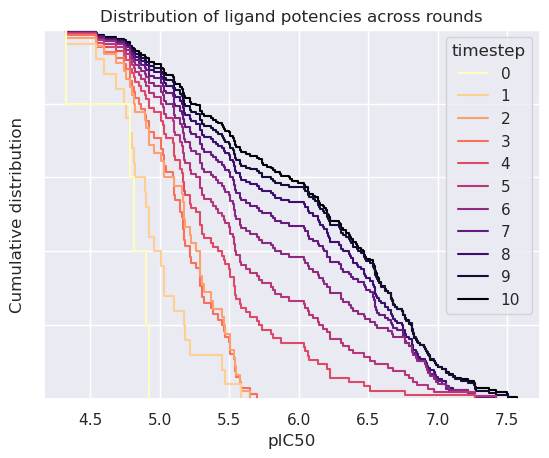

In [397]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

g = sns.ecdfplot(
    df,
    x='score',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')